In [ ]:
import geopandas as gpd

import pandas as pd

In [63]:
meta_input = input("Enter the file path: ")

metadata = pd.read_csv(
    meta_input,
)

In [ ]:
metadata.head(40)

In [ ]:
# find row where SHP/* equals acoewrig
row = metadata[metadata["SHP/*"] == "acoewrig"].index[0]

row

sliice = metadata.iloc[row:, :]

sliice

In [ ]:
# create new dataframe with latin names, common names, and shp/* columns from metadata

metadata = metadata[["Latin Name", "Common Name", "SHP/*"]]

metadata.head()

In [ ]:
check_input = input("Enter the file path: ")

check = pd.read_parquet(check_input)

check

In [421]:
little = gpd.read_file(
    "/media/muskrat/T7 Shield/eco_data/v3/native/little/7445016/wpetry/USTreeAtlas-v1.0/wpetry-USTreeAtlas-4999258/geojson/querhypo.geojson"
)

little

,AREA,PERIMETER,QUERHYPO_,QUERHYPO_I,CODE,geometry
0,0.020640,0.512944,2.0,1.0,1,"POLYGON ((-109.54794 33.67374, -109.55305 33.6..."
1,0.190562,2.291291,3.0,2.0,1,"POLYGON ((-108.82774 33.39902, -108.80132 33.4..."
2,0.135203,1.675381,4.0,4.0,1,"POLYGON ((-107.69701 33.22118, -107.63190 33.2..."
3,0.037279,0.727241,5.0,3.0,1,"POLYGON ((-109.29910 33.23054, -109.26241 33.2..."
4,0.019796,0.501837,6.0,5.0,1,"POLYGON ((-109.77525 32.64484, -109.78008 32.6..."
5,0.017483,0.471573,7.0,6.0,1,"POLYGON ((-109.11250 32.52914, -109.11922 32.5..."
6,0.035976,0.708067,8.0,7.0,1,"POLYGON ((-110.74578 32.41907, -110.66815 32.4..."
7,0.020296,0.507909,9.0,9.0,1,"POLYGON ((-109.56199 32.16077, -109.56701 32.1..."
8,0.018845,0.489399,10.0,8.0,1,"POLYGON ((-111.15611 32.12274, -111.16342 32.1..."
9,0.106494,1.289198,11.0,11.0,1,"POLYGON ((-109.39238 32.05708, -109.36338 32.0..."


In [ ]:
little.crs

In [422]:
little = little.to_crs("EPSG:4326")

little.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

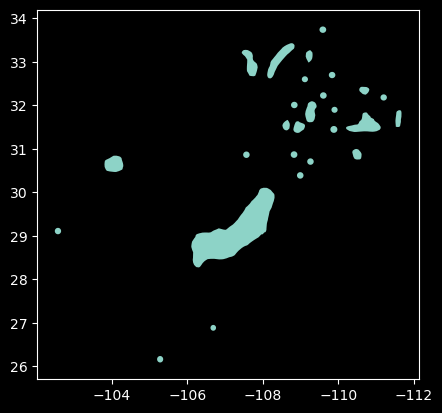

In [423]:
little.plot().invert_xaxis()

In [ ]:
ecomap_loc = "/media/muskrat/T7 Shield/eco_data/ecomap_final/eco_map.geojson"

eco_map = gpd.read_file(ecomap_loc)

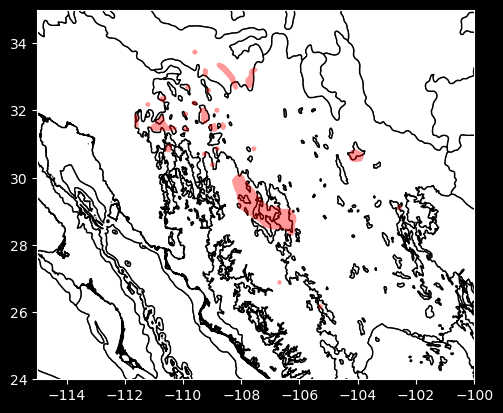

In [424]:
base = eco_map.plot(color="white", edgecolor="black")
xmin, ymin, xmax, ymax = (-100, 24, -115, 35)

ax = little.plot(ax=base, color="red", alpha=0.4)

# set the x and y limits of the plot to the specified bounding box coordinates
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.invert_xaxis()

/tmp/ipykernel_5384/3949426135.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlay["area"] = overlay.geometry.area
/tmp/ipykernel_5384/3949426135.py:29: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  eco_map_unique["area"] = eco_map_unique.geometry.area


,overlay_area,eco_map_unique_area,percentage
unique_id,,,
310,1.476750,20.164750,0.073234
311,0.090112,5.871670,0.015347
331,0.328782,10.662979,0.030834
415,1.052756,47.472658,0.022176
422,0.037392,21.235873,0.001761


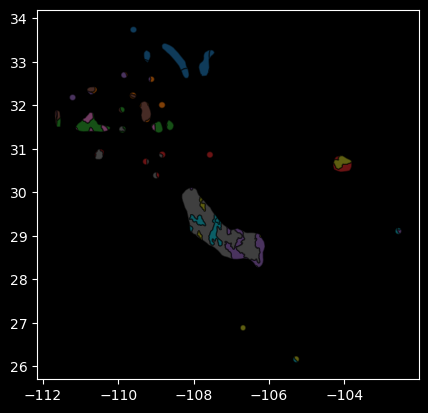

In [425]:
intersects = gpd.sjoin(little, eco_map)

unique_ids = list(intersects["unique_id"].unique())

eco_map_unique = eco_map[eco_map["unique_id"].isin(unique_ids)]

# remove rows with <NA> in unique_id from eco_map_unique

eco_map_unique = eco_map_unique[eco_map_unique["unique_id"] != "<NA>"]

# remove rows withe MEOW or PPOW in TYPE from eco_map_unique

eco_map_unique = eco_map_unique[~eco_map_unique["TYPE"].isin(["MEOW", "PPOW"])]

overlay = gpd.overlay(little, eco_map, how="intersection")

overlay = overlay[overlay["unique_id"] != "<NA>"]

# remove rows with MEOW or PPOW in TYPE from overlay

overlay = overlay[~overlay["TYPE"].isin(["MEOW", "PPOW"])]

overlay.plot(alpha=0.5, edgecolor="k", cmap="tab10")

overlay["area"] = overlay.geometry.area

overlay_areas = overlay[["unique_id", "area"]].groupby("unique_id").sum()

eco_map_unique["area"] = eco_map_unique.geometry.area

eco_map_unique_areas = eco_map_unique[["unique_id", "area"]].groupby("unique_id").sum()

combined_areas = pd.concat([overlay_areas, eco_map_unique_areas], axis=1)
combined_areas.columns = ["overlay_area", "eco_map_unique_area"]

combined_areas["percentage"] = (
    combined_areas["overlay_area"] / combined_areas["eco_map_unique_area"]
)

combined_areas

In [426]:
native = ["310", "331", "415"]

native

['310', '331', '415']

In [427]:
shp = "querhypo"

scientific_name = metadata.loc[metadata["SHP/*"] == shp]["Latin Name"].values[0]

common_name = metadata.loc[metadata["SHP/*"] == shp]["Common Name"].values[0]
# final dataframe
final = pd.DataFrame(
    {
        "scientific_name": scientific_name,
        "common_name": common_name,
        "unique_id": native,
        "database": "little",
    },
)

# groupby scientific_name
final = (
    final.groupby(["scientific_name", "common_name"])["unique_id"]
    .apply(list)
    .reset_index()
)


final

,scientific_name,common_name,unique_id
0,Quercus hypoleucoides,silverleaf oak,"[310, 331, 415]"


In [428]:
string_name = str(final["scientific_name"].values[0]).replace(" ", "_")

final_base_path = "/media/muskrat/T7 Shield/eco_data/v3/native/little/checked/"
path = final_base_path + string_name + ".parquet"

final.to_parquet(path)

In [ ]:
quermohr > 0.03 - 379, 391, 415
quertoum > 0.009 - 310
rhuschor > 0.01 - 310, 415
robikels > 0.01 - 314 overlay - 0.2
robivisc > 0.04 - 314

In [ ]:
intersects = gpd.sjoin(little, eco_map)

intersects

In [ ]:
# put unique values of unique_id in intersects into a list

unique_ids = list(intersects["unique_id"].unique())
unique_ids

In [ ]:
# create dataframe from eco_map that only contains the unique ids in unique_ids

eco_map_unique = eco_map[eco_map["unique_id"].isin(unique_ids)]
eco_map_unique

In [ ]:
# remove rows with <NA> in unique_id from eco_map_unique

eco_map_unique = eco_map_unique[eco_map_unique["unique_id"] != "<NA>"]

# remove rows withe MEOW or PPOW in TYPE from eco_map_unique

eco_map_unique = eco_map_unique[~eco_map_unique["TYPE"].isin(["MEOW", "PPOW"])]

eco_map_unique

In [ ]:
eco_map_unique.plot()

In [ ]:
overlay = gpd.overlay(little, eco_map, how="intersection")

overlay

In [ ]:
# remove rows with <NA> in unique_id from overlay

overlay = overlay[overlay["unique_id"] != "<NA>"]

# remove rows with MEOW or PPOW in TYPE from overlay

overlay = overlay[~overlay["TYPE"].isin(["MEOW", "PPOW"])]

overlay

In [ ]:
overlay.plot(alpha=0.5, edgecolor="k", cmap="tab10")

In [ ]:
overlay["area"] = overlay.geometry.area

overlay

In [ ]:
# create a new dataframe from overlay where the first column is unique_id and the second column is the area of all the rows in overlay that have the same unique_id

overlay_areas = overlay[["unique_id", "area"]].groupby("unique_id").sum()

overlay_areas

In [ ]:
# add an area column to eco_map_unique dataframe

eco_map_unique["area"] = eco_map_unique.geometry.area

eco_map_unique

In [ ]:
# create a new dataframe from eco_map_unique where the first column is unique_id and the second column is the area of all the rows in eco_map_unique that have the same unique_id

eco_map_unique_areas = eco_map_unique[["unique_id", "area"]].groupby("unique_id").sum()

eco_map_unique_areas

In [ ]:
# combine eco_map_unique_areas and overlay_areas into a new dataframe where the first column is unique_id, the second column is area from overlays, and the third column is area from eco_map_unique

combined_areas = pd.concat([overlay_areas, eco_map_unique_areas], axis=1)
combined_areas.columns = ["overlay_area", "eco_map_unique_area"]

combined_areas

In [ ]:
combined_areas["percentage"] = (
    combined_areas["overlay_area"] / combined_areas["eco_map_unique_area"]
)

combined_areas

In [ ]:
intersects = gpd.sjoin(little, eco_map)

unique_ids = list(intersects["unique_id"].unique())

eco_map_unique = eco_map[eco_map["unique_id"].isin(unique_ids)]

# remove rows with <NA> in unique_id from eco_map_unique

eco_map_unique = eco_map_unique[eco_map_unique["unique_id"] != "<NA>"]

# remove rows withe MEOW or PPOW in TYPE from eco_map_unique

eco_map_unique = eco_map_unique[~eco_map_unique["TYPE"].isin(["MEOW", "PPOW"])]

overlay = gpd.overlay(little, eco_map, how="intersection")

overlay = overlay[overlay["unique_id"] != "<NA>"]

# remove rows with MEOW or PPOW in TYPE from overlay

overlay = overlay[~overlay["TYPE"].isin(["MEOW", "PPOW"])]

overlay.plot(alpha=0.5, edgecolor="k", cmap="tab10")

overlay["area"] = overlay.geometry.area

overlay_areas = overlay[["unique_id", "area"]].groupby("unique_id").sum()

eco_map_unique["area"] = eco_map_unique.geometry.area

eco_map_unique_areas = eco_map_unique[["unique_id", "area"]].groupby("unique_id").sum()

combined_areas = pd.concat([overlay_areas, eco_map_unique_areas], axis=1)
combined_areas.columns = ["overlay_area", "eco_map_unique_area"]

combined_areas["percentage"] = (
    combined_areas["overlay_area"] / combined_areas["eco_map_unique_area"]
)

combined_areas

In [ ]:
quermohr > 0.03
quertoum > 0.009 - 310
rhuschor > 0.01 - 310, 415

In [ ]:
# if overlay_area / eco_map_unique_area > 0.2 then add unique_id to list of ids

# if length of combined_areas == 1 then native = unique_ids

if len(combined_areas) == 1:
    native = unique_ids
else:

    native = combined_areas[
        combined_areas["overlay_area"] / combined_areas["eco_map_unique_area"] > 0.2
    ].index.tolist()

    print(len(native))

    if len(native) == 0:
        print("test")
        native = combined_areas[
            combined_areas["eco_map_unique_area"] <= 2
        ].index.tolist()
        print(native)
        if len(native) == 0:
            native = combined_areas[
                combined_areas["overlay_area"] / combined_areas["eco_map_unique_area"]
                > 0.1
            ].index.tolist()
            print(native)

native

native_df = eco_map[eco_map["unique_id"].isin(native)]

native_df

In [ ]:
native_df = eco_map[eco_map["unique_id"].isin(native)]

native_df

In [ ]:
native_df.plot()

In [ ]:
# scientific_name equals the Latin Name in metadata at value of SHP/*

scientific_name = metadata.loc[metadata["SHP/*"] == "acacchor"]["Latin Name"].values[0]


common_name = metadata.loc[metadata["SHP/*"] == "acacchor"]["Common Name"].values[0]

# final dataframe

final = pd.DataFrame(
    {
        "scientific_name": scientific_name,
        "common_name": common_name,
        "unique_id": native,
    },
)


# groupby scientific_name
final = (
    final.groupby(["scientific_name", "common_name"])["unique_id"]
    .apply(list)
    .reset_index()
)

final

In [ ]:
# write to parquet file

# path equals scientific_name from final without spaces and converted to string

string_name = str(final["scientific_name"].values[0]).replace(" ", "_")

base_path = input("Enter the base path: ")

path = base_path + string_name + ".parquet"

final.to_parquet(path)

In [ ]:
little_base = input("Enter the little base file path: ")

final_base_path = input("Enter the final base path: ")

for shp in metadata["SHP/*"]:
    print(shp)
    path = f"{little_base}{shp}.geojson"

    little = gpd.read_file(
        path,
    )

    # convert crs
    little = little.to_crs("EPSG:4326")

    # find intersecting geometry
    intersects = gpd.sjoin(little, eco_map)

    # put unique values of unique_id in intersects into a list
    unique_ids = list(intersects["unique_id"].unique())

    # create dataframe from eco_map that only contains the unique ids in unique_ids
    eco_map_unique = eco_map[eco_map["unique_id"].isin(unique_ids)]

    # remove rows with <NA> in unique_id from eco_map_unique
    eco_map_unique = eco_map_unique[eco_map_unique["unique_id"] != "<NA>"]

    # find overlaying geometry
    overlay = gpd.overlay(little, eco_map, how="intersection")

    # remove rows with <NA> in unique_id from overlay
    overlay = overlay[overlay["unique_id"] != "<NA>"]

    # add area column to overlay
    overlay["area"] = overlay.geometry.area

    # create a new dataframe from overlay where the first column is unique_id and the second column is the area of all the rows in overlay that have the same unique_id
    overlay_areas = overlay[["unique_id", "area"]].groupby("unique_id").sum()

    # add an area column to eco_map_unique dataframe
    eco_map_unique["area"] = eco_map_unique.geometry.area

    # create a new dataframe from eco_map_unique where the first column is unique_id and the second column is the area of all the rows in eco_map_unique that have the same unique_id
    eco_map_unique_areas = (
        eco_map_unique[["unique_id", "area"]].groupby("unique_id").sum()
    )

    # combine eco_map_unique_areas and overlay_areas into a new dataframe where the first column is unique_id, the second column is area from overlays, and the third column is area from eco_map_unique
    combined_areas = pd.concat([overlay_areas, eco_map_unique_areas], axis=1)
    combined_areas.columns = ["overlay_area", "eco_map_unique_area"]

    # if overlay_area / eco_map_unique_area > 0.2 then add unique_id to list of ids
    native = combined_areas[
        combined_areas["overlay_area"] / combined_areas["eco_map_unique_area"] > 0.2
    ].index.tolist()

    # convert to df
    native_df = eco_map[eco_map["unique_id"].isin(native)]

    # scientific_name equals the Latin Name in metadata at value of SHP/*
    scientific_name = metadata.loc[metadata["SHP/*"] == shp]["Latin Name"].values[0]
    print(scientific_name)

    common_name = metadata.loc[metadata["SHP/*"] == shp]["Common Name"].values[0]
    print(common_name)
    # final dataframe
    final = pd.DataFrame(
        {
            "scientific_name": scientific_name,
            "common_name": common_name,
            "unique_id": native,
        },
    )

    # groupby scientific_name
    final = (
        final.groupby(["scientific_name", "common_name"])["unique_id"]
        .apply(list)
        .reset_index()
    )

    print(final)

    string_name = str(final["scientific_name"].values[0]).replace(" ", "_")

    path = final_base_path + string_name + ".parquet"
    print(path)

    final.to_parquet(path)

In [ ]:
import os

base_path = input("Enter the base path: ")

# find all the file names in the directory
# files = os.listdir(base_path)
files = os.listdir("/media/muskrat/T7 Shield/eco_data/v3/native/little/final")


# read each file into a dataframe
check = pd.DataFrame()
for file in files:

    df = pd.read_parquet(f"{base_path}/{file}")
    # if unique_ids column = ['test'] then append to check dataframe
    # print(df["unique_id"].values[0][0])

    if df["unique_id"].values[0][0] == "check":
        # print("test")
        check = check.append(df)

check

In [ ]:
# create new dataframe from metadata where scientific_name in check == Latin Name in metadata

check_meta = metadata[metadata["Latin Name"].isin(check["scientific_name"])]

check_meta

In [ ]:
scientific = [
    "Alnus maritima",
    "Ceanothus spinosus",
    "Celtis lindheimeri",
    "Crataegus erythropoda",
    "Crataegus saligna",
    "Crataegus tracyi",
    "Cupressus bakeri",
    "Cupressus guadalupensis",
    "Cupressus macrocarpa",
    "Elliottia racemosa",
    "Fraxinus gooddingii",
    "Fraxinus papillosa",
    "Fremontodendron mexicanum",
    "Halesia parviflora",
    "Ilex amelanchier",
    "Juglans hindsii",
    "Leitneria floridana",
    "Nemopanthus collinus",
    "Ostrya chisosensis",
    "Ostrya knowltonii",
    "Pinus balfouriana",
    "Pinus culminicola",
    "Pinus nelsonii",
    "Pinus pinceana",
    "Pinus washoensis",
    "Pistacia texana",
    "Populus hinckleyana",
    "Prunus alleghaniensis",
    "Prunus lyonii",
    "Quercus ajoensis",
    "Quercus arkansana",
    "Quercus georgiana",
    "Quercus graciliformis",
    "Quercus gravesii",
    "Quercus hypoleucoides",
]

check_meta_2 = metadata[metadata["Latin Name"].isin(scientific)]

check_meta_2

In [ ]:
# concat the two dataframes check_meta and check_meta_2

combined = pd.concat([check_meta, check_meta_2])

combined

In [ ]:
# final_1 equals rows in metadata that are not in combined

final_1 = metadata[~metadata["Latin Name"].isin(combined["Latin Name"])]

final_1

In [ ]:
# read in all the parquet files in the folder where path ends in Latin Name + .parquet of final_1
path = input("Enter the file path: ")

final_2 = pd.DataFrame()

for latin_name in final_1["Latin Name"]:
    file = path + latin_name.replace(" ", "_") + ".parquet"

    df = pd.read_parquet(file)
    final_2 = final_2.append(df)

final_2

In [ ]:
final_2.to_parquet(
    "/media/muskrat/T7 Shield/eco_data/v3/native/little/new_final/finished.parquet"
)

In [ ]:
combined.to_parquet("/home/muskrat/Desktop/check.parquet")